In [1]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224707 sha256=ea85f5f7897e494c90e49a560b70e32e676bb5447b3b60f99b76eedb9054531d
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [2]:
from glob import glob
import torch
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from torchvision.transforms import v2 as T
import albumentations as A
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
import torch.nn.functional as F
from torchmetrics import JaccardIndex
from albumentations.pytorch import ToTensorV2
import os
from medpy.io import load, header

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def path(fname, num):
    return f'/kaggle/input/liver-3k/Train_Sets/CT/' + fname

def get_data(num):
    X_path = path('', num)
    X_filenames = []
    y_filenames = []
    for directory in tqdm_notebook(os.listdir(X_path)[:-1], position=0):
        for dirName, subdirList, fileList in os.walk(X_path+directory):
            for filename in fileList:
                if ".dcm" in filename.lower():
                    X_filenames.append(os.path.join(dirName, filename))
                if ".png" in filename.lower():
                    y_filenames.append(os.path.join(dirName, filename))
    assert len(X_filenames) == len(y_filenames)
    return sorted(X_filenames), sorted(y_filenames)

In [4]:
X_filenames1, y_filenames1 = get_data(1)

X_filenames = X_filenames1
y_filenames = y_filenames1

len(X_filenames), len(y_filenames)
# print(X_filenames)
# print(y_filenames)

/tmp/ipykernel_30/3501377374.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for directory in tqdm_notebook(os.listdir(X_path)[:-1], position=0):


  0%|          | 0/19 [00:00<?, ?it/s]

(2751, 2751)

In [5]:
class LiverDF:
    def __init__(self, X_filenames, y_filenames, augmentation):
        self.features = []
        self.targtes = []
        
        mean, std = (-485.18832664531345, 492.3121911082333)
        
        self.augmentation = augmentation
        
        self.trans_standart = A.Compose([
            A.Resize(height=512, width=512),
#             ToTensorV2(),
        ])
        
        data = np.concatenate([np.array(X_filenames)[:, np.newaxis], 
                               np.array(y_filenames)[:, np.newaxis]],axis=1)
        
        cnt = 0
        for path_x, path_y in tqdm(data):
            ans = self.trans_standart(image=(load(path_x)[0] - mean) / std, mask=load(path_y)[0] / 255)
            self.features.append(ans['image'])
            self.targtes.append(ans['mask'])
            
    
    def __getitem__(self, index):
        ans = self.augmentation(image=self.features[index], mask=self.targtes[index])
        return ans['image'], ans['mask']
    
    def __len__(self):
        return len(self.features)

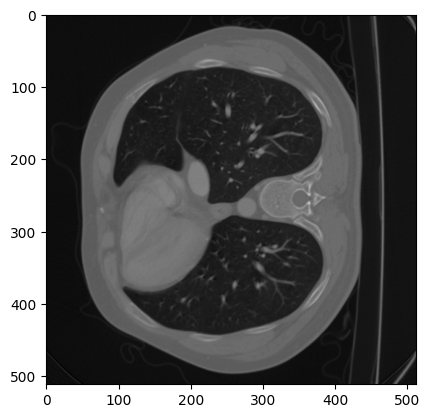

In [7]:
plt.imshow(load(X_filenames[0])[0], cmap='gray')
plt.imshow(load(y_filenames[0])[0], cmap='gray', alpha=0.2)

In [8]:
transform_train = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=15, p=0.5),
    A.Resize(height=512, width=512),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(height=512, width=512),
    ToTensorV2(),
])

In [9]:
n_train = int(len(X_filenames) * 0.7)
df_train = LiverDF(X_filenames[:n_train], y_filenames[:n_train], transform_train)
df_test = LiverDF(X_filenames[n_train:], y_filenames[n_train:], transform_val)

100%|██████████| 826/826 [00:26<00:00, 30.67it/s]


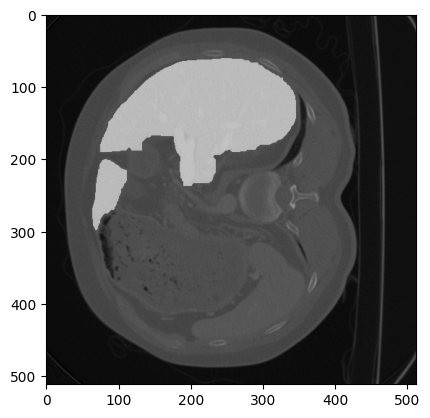

In [10]:
show_list = df_train[50]

plt.imshow(show_list[0].squeeze(0), cmap='gray')
plt.imshow(show_list[1], alpha=0.4, cmap='gray')

In [121]:
mean = np.empty(len(df_train))
std = np.empty(len(df_train))
for i, (x, y) in enumerate(df_train):
    mean[i] = x.mean()
    std[i] = x.std()
mean = mean.mean()
std = std.mean()

In [11]:
batch_size = 4
tr_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

In [12]:
def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 8

        self.down1 = conv_plus_conv(1, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)
        self.up5 = conv_plus_conv(base_channels * 32, base_channels * 8)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=1, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual1 = self.down1(x)  
        x = self.downsample(residual1) 

        residual2 = self.down2(x)  
        x = self.downsample(residual2)
        
        residual3 = self.down3(x)
        x = self.downsample(residual3)
        
        residual4 = self.down4(x)
        x = self.downsample(residual4) 
        
        residual5 = self.down5(x)
        x = self.downsample(residual5) 
            
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual5), dim=1)
        x = self.up5(x)
    
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)  
        x = self.up1(x)  

        return self.sigmoid(self.out(x))

In [13]:
def train(model, loader):
    model.train()

    train_loss = 0
    dice_coef = 0

    for x, y in tqdm(loader, desc='Train'):
        x, y = x.to(device).float(), y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        pred = model(x)
        
        loss = loss_fn(pred, y)
        dice_coef += DiceCoef()(pred > 0.9, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
    scheduler.step()

    return train_loss / len(loader), dice_coef.item() / len(loader)

In [14]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    val_loss = 0
    jaccard_cnt = 0
    precision_cnt = 0
    recall_cnt = 0
    precision_cnter = 0
    recall_cnter = 0
    jaccard_tumor_cnt = 0
    dice_coef = 0

    for x, y in tqdm(loader, desc='Test'):
        x, y = x.to(device).float(), y.to(device).float().unsqueeze(1)

        pred = model(x)

        loss = loss_fn(pred, y)

        val_loss += loss.item()
        dice_coef += DiceCoef()(pred > 0.9, y)

        

        
    
    return val_loss / len(loader), dice_coef.item() / len(loader)

In [15]:
def plot_stats(train_loss, valid_loss, train_dice, val_dice):
    plt.figure(figsize=(16, 8))

    plt.title('loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title('dice liver')
    
    plt.plot(train_dice, label='Train dice')
    plt.plot(val_dice, label='Valid dice')
    plt.legend()
    plt.grid()

    plt.show()

In [16]:
def epoh_train(model, tr_loader, valid_loader, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_dice_history, valid_dice_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_dice = train(model, tr_loader)
        valid_loss, valid_dice = evaluate(model, valid_loader)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_dice_history.append(train_dice)
        valid_dice_history.append(valid_dice)
        
        clear_output()
        
        print('lr:', scheduler.get_last_lr()[0])
        print('tr_loss:', train_loss)
        print('val_loss:', valid_loss)
        print('tr_dice:', train_dice)
        print('val_dice:', valid_dice)
        
        plot_stats(
            train_loss_history, valid_loss_history,
            train_dice_history, valid_dice_history,
        )

In [17]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets):
        return 1 - DiceCoef()(inputs, targets)

In [19]:
class DiceCoef(nn.Module):
    def __init__(self, smooth=1e-20):
        super(DiceCoef, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()
        total = inputs.sum() + targets.sum()

        dice_coef = (2. * intersection + self.smooth) / (total + self.smooth)
        
        return dice_coef

In [22]:
device = torch.device('cuda:0')
# device = torch.device('cpu')
unet_model = UNET().to(device)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

lr: 0.0003486784401
tr_loss: 0.6695965783759611
val_loss: 0.6742083911158613
tr_dice: 0.9749627063775013
val_dice: 0.8848712571001284


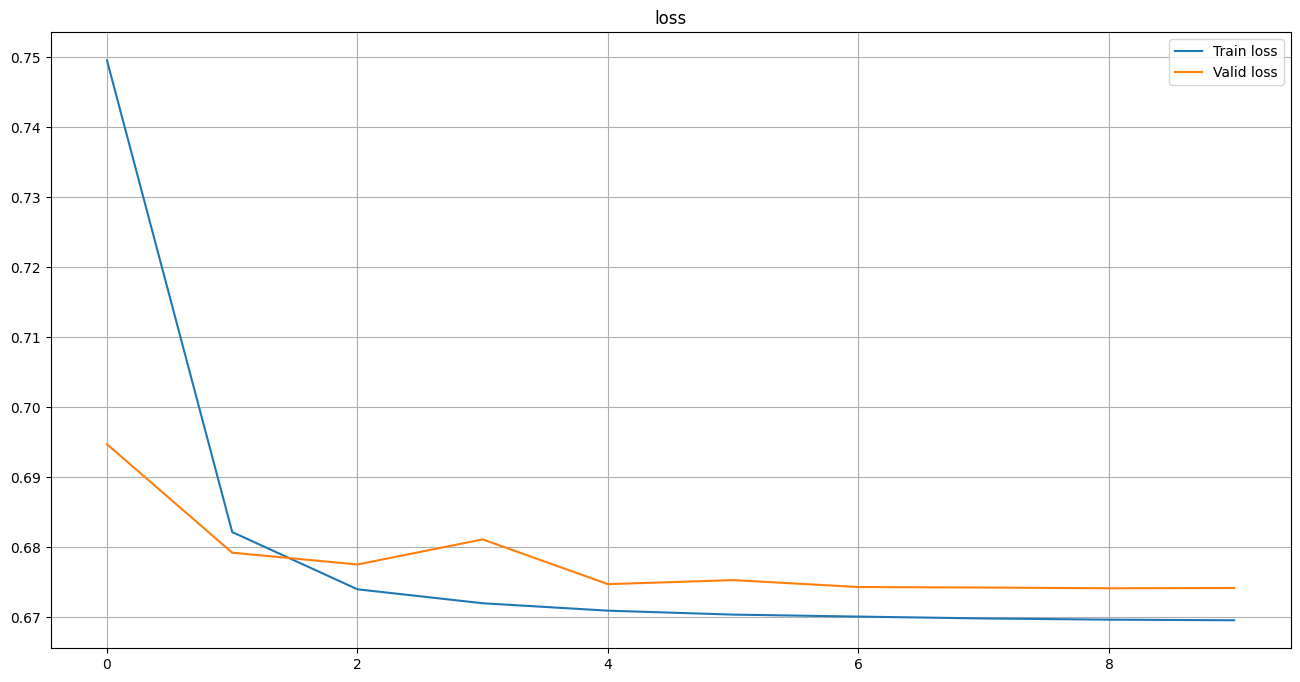

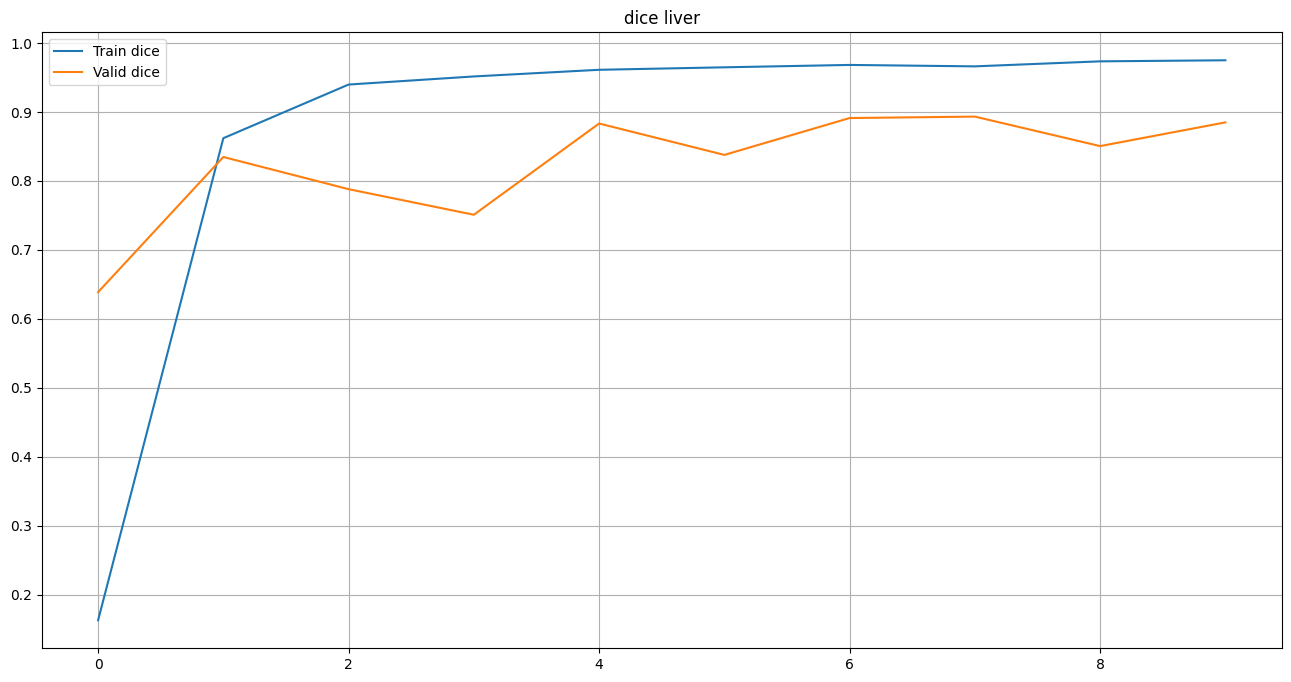

In [23]:
epoh_train(unet_model, tr_loader, val_loader, 10)

In [24]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

lr: 3.4867844010000016e-05
tr_loss: 0.6691189398388853
val_loss: 0.6737860792500961
tr_dice: 0.9800141586335434
val_dice: 0.9046493014275739


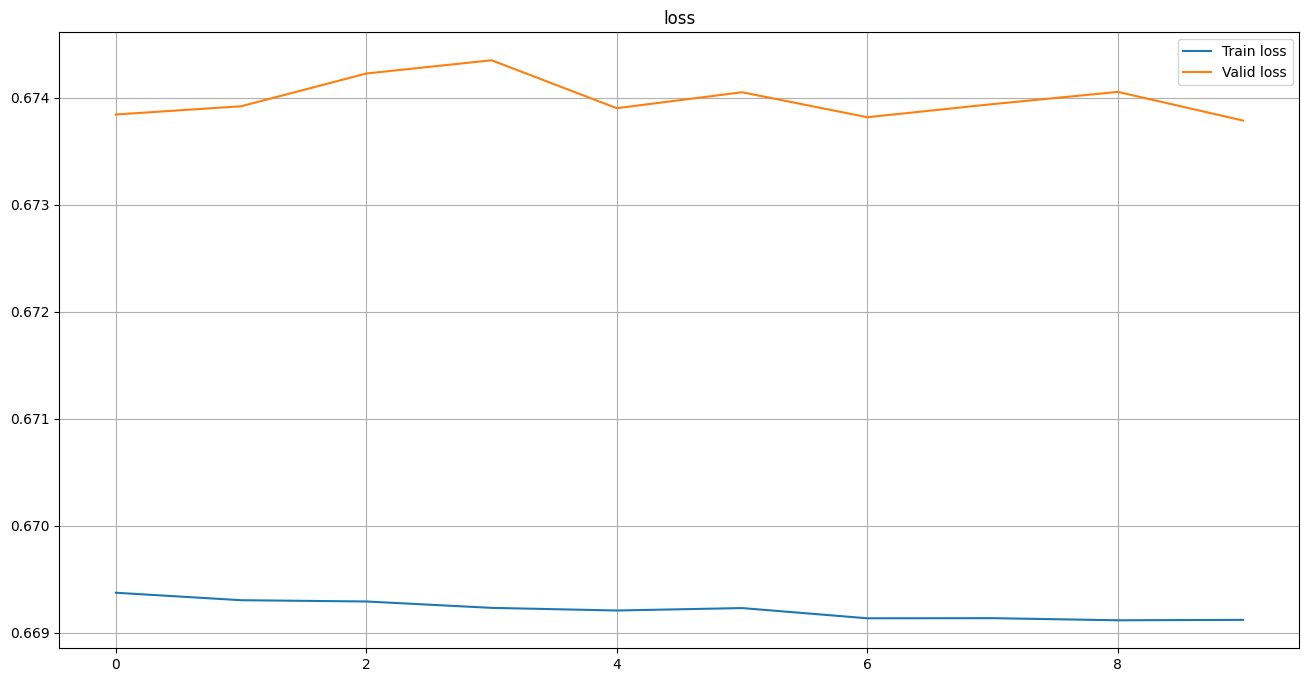

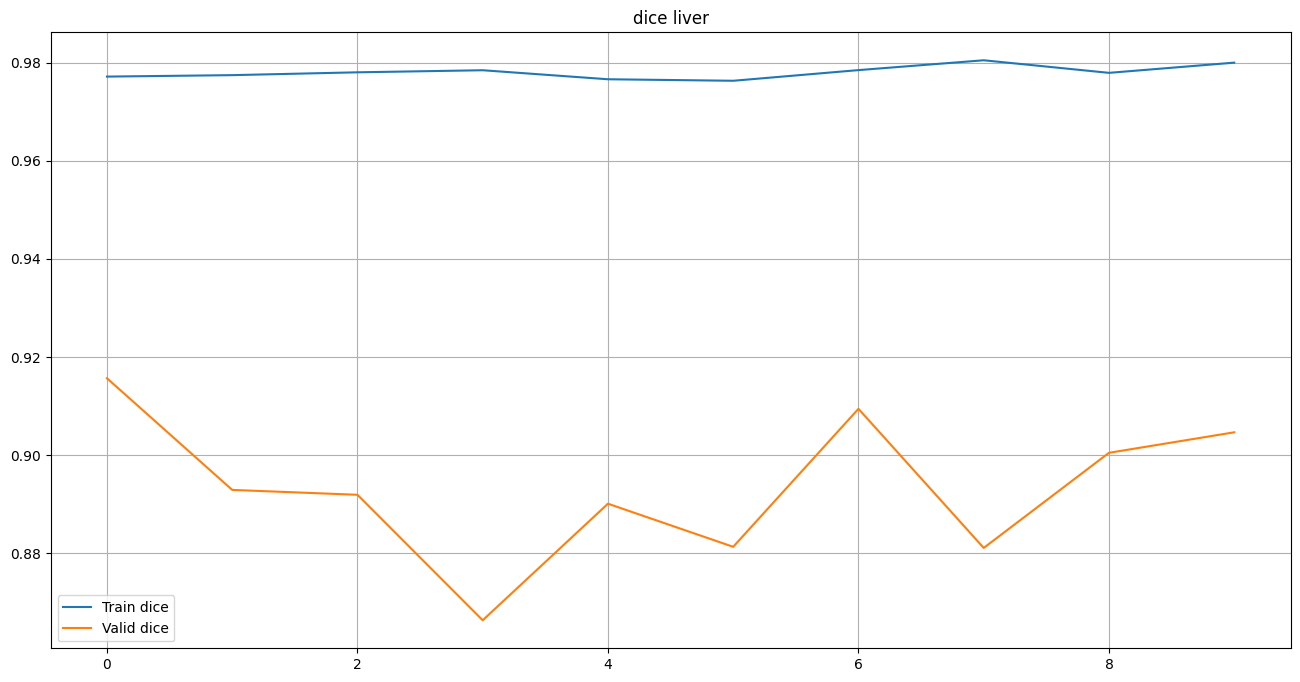

In [25]:
epoh_train(unet_model, tr_loader, val_loader, 10)

lr: 0.000387420489
tr_loss: 0.6708932198177684
val_loss: 0.6708986556184464
tr_dice: 0.9630445445667614
val_dice: 0.7951753588690273


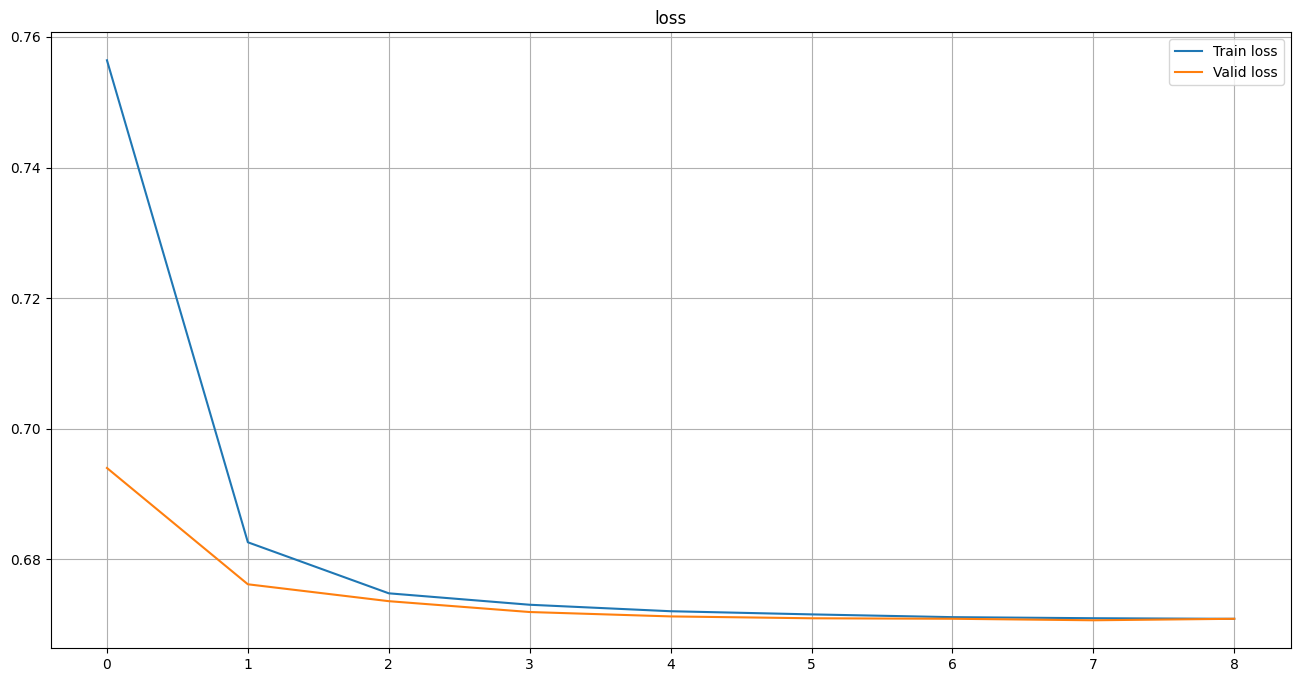

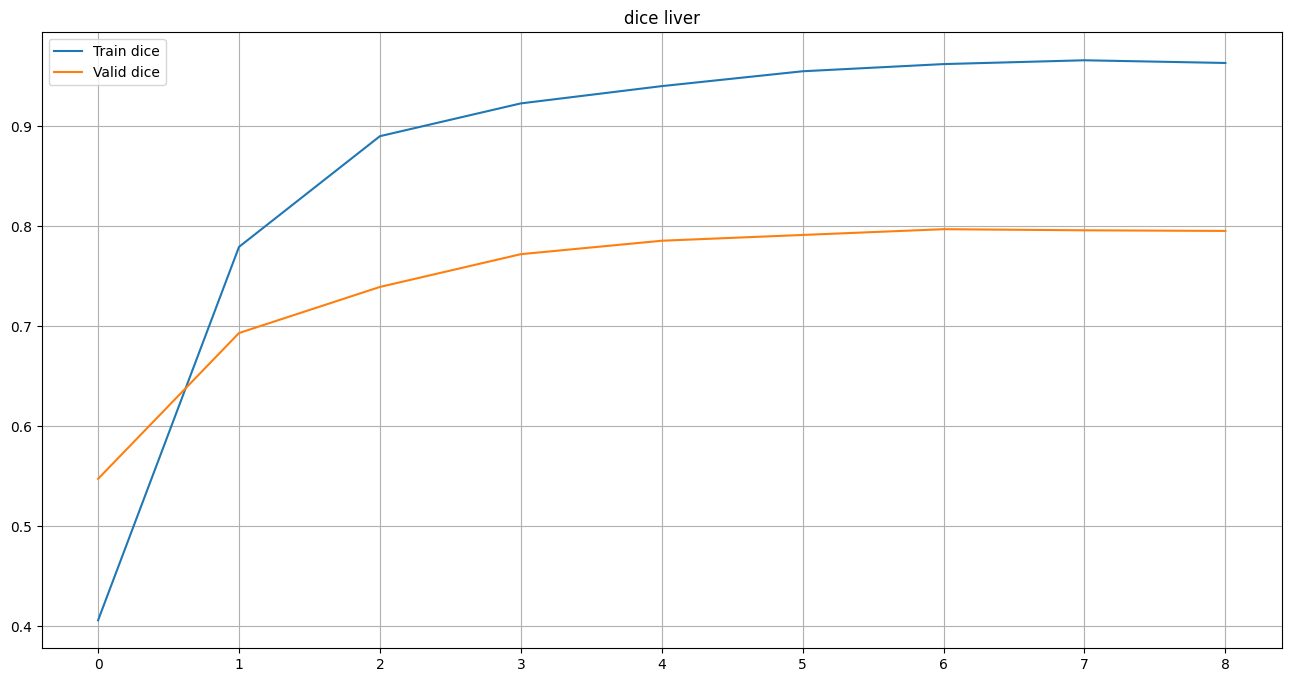

Train:   7%|▋         | 38/550 [00:04<01:01,  8.29it/s]


KeyboardInterrupt: 

In [18]:
epoh_train(unet_model, tr_loader, val_loader, 30)

lr: 0.00031381059609000004
tr_loss: 0.6708870411961836
val_loss: 0.6766431440794191
tr_dice: 0.9140872343636115
val_dice: 0.597014493720476


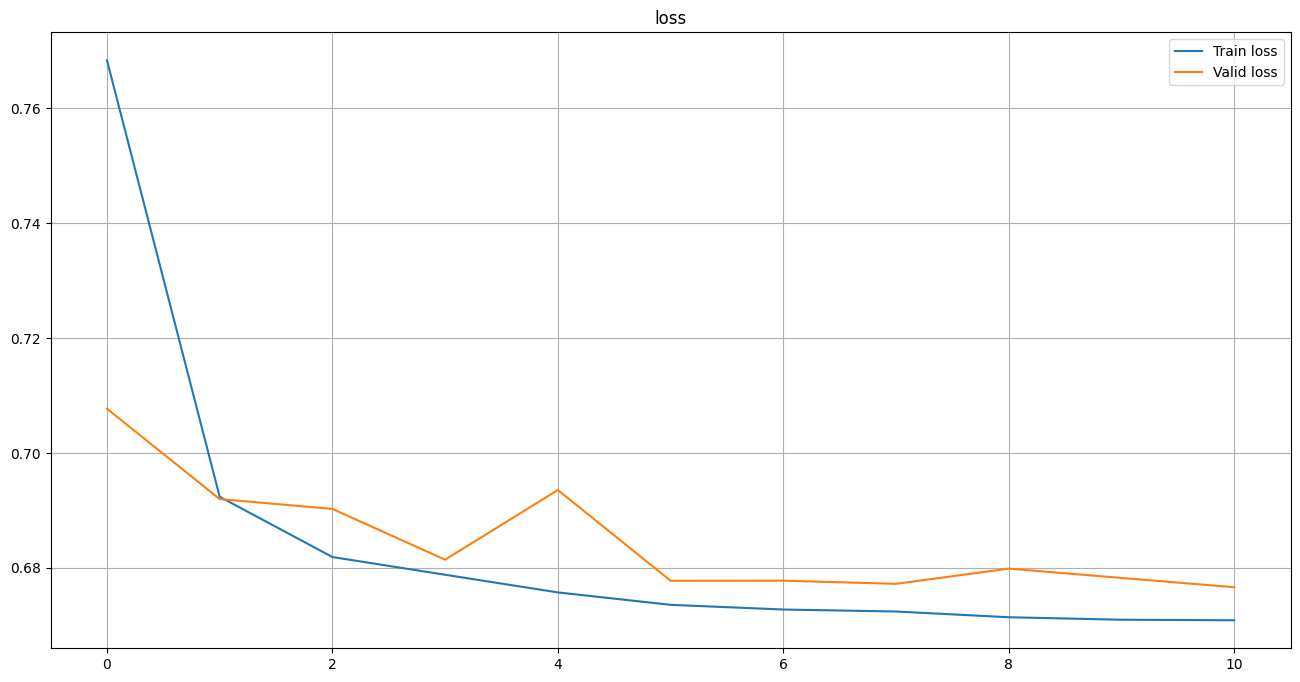

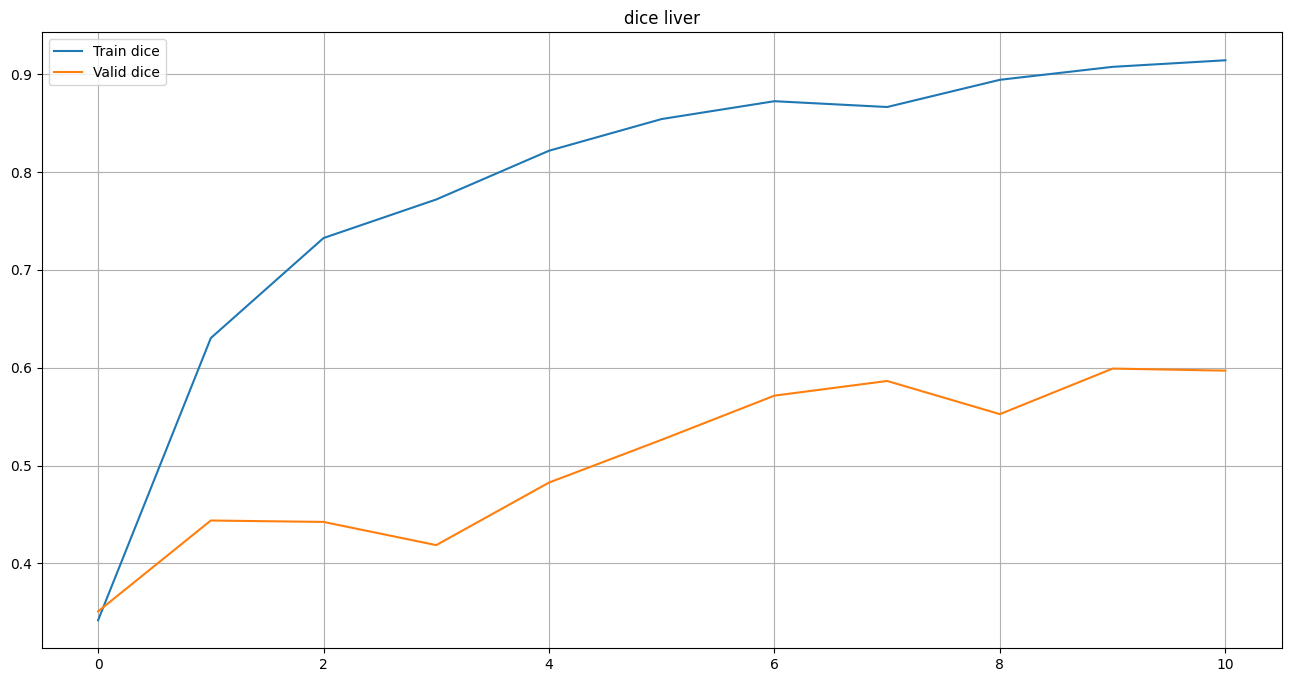

Train:  17%|█▋        | 60/343 [00:10<00:47,  5.99it/s]


KeyboardInterrupt: 

In [31]:
epoh_train(unet_model, tr_loader, val_loader, 20)

lr: 0.001215766545905694
tr_loss: 0.07217041477802116
val_loss: 0.1897863028705984
tr_dice: 0.9278295852219789
val_dice: 0.8102136971294016


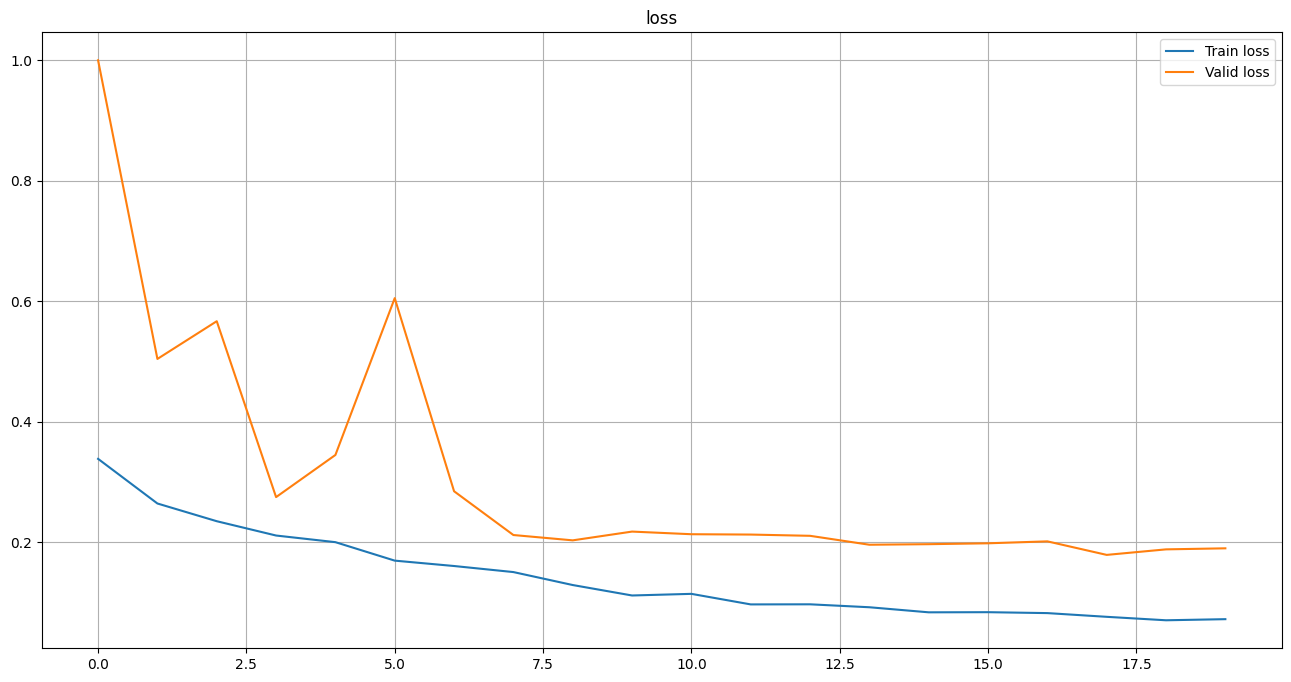

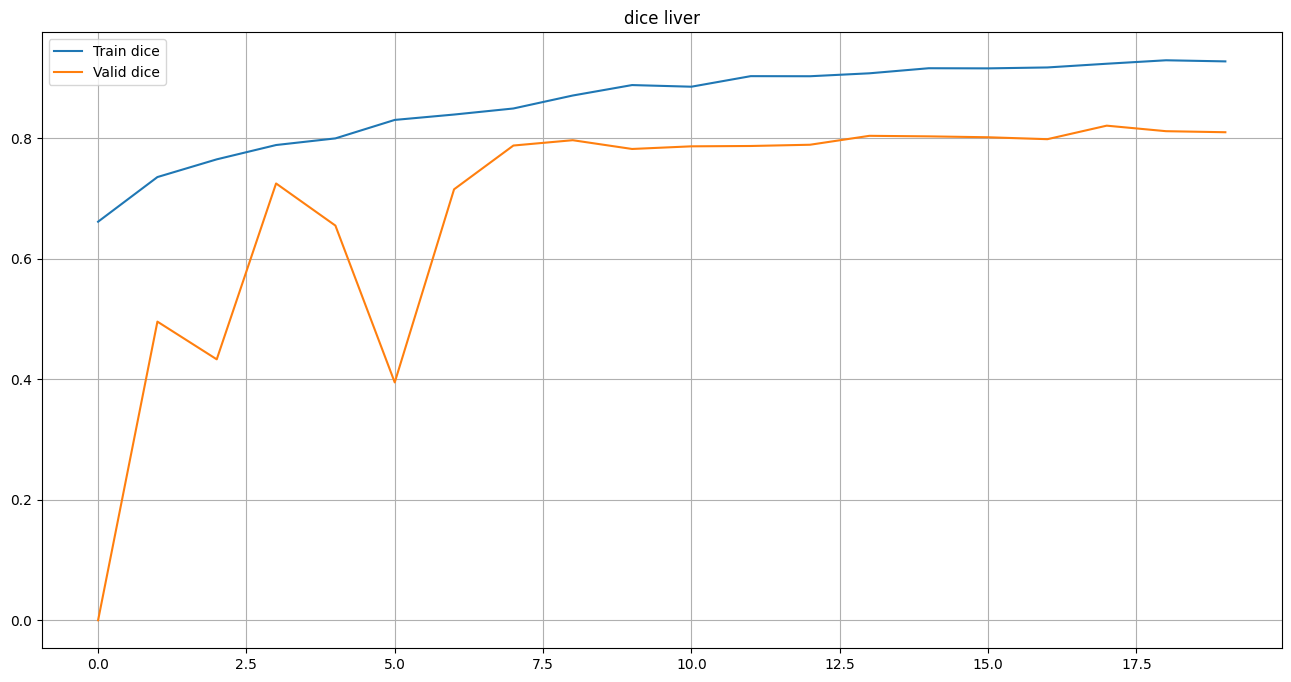

In [18]:
epoh_train(unet_model, tr_loader, val_loader, 20)

In [99]:
import cv2

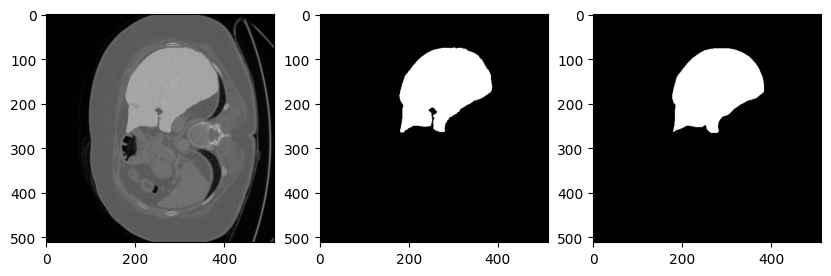

In [30]:
unet_model = unet_model.eval()
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,15)

index = 100
ax[0].imshow(df_test[index][0].squeeze(0), cmap='gray')
ax[0].imshow(unet_model(df_test[index][0].to(device).float().unsqueeze(0)).squeeze(0, 1).cpu().detach(), alpha=0.2, cmap='gray')
ax[1].imshow(unet_model(df_test[index][0].to(device).float().unsqueeze(0)).squeeze(0, 1).cpu().detach() > 0.9, cmap='gray')
ax[2].imshow(df_test[index][1], cmap='gray')

In [104]:
def show_result(df, index):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    df_temp = df[index]
    image = df_temp[0]
    mask = df_temp[1]
    p = unet_model(df_temp[0].to(device).float().unsqueeze(0)).squeeze(0).cpu().detach() > 0.9

    mask_8uc1 = (mask.numpy().squeeze() * 255).astype(np.uint8)
    pred_8uc1 = (p.numpy().squeeze() * 255).astype(np.uint8)

    contours_true, _ = cv2.findContours(mask_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pred, _ = cv2.findContours(pred_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.imshow(mask.squeeze(), alpha=0.5, cmap='autumn')
    for contour in contours_true:
        ax1.plot(contour[:, 0, 0], contour[:, 0, 1], 'b', linewidth=2)
    ax1.set_title('Истинная маска')

    ax2.imshow(image.squeeze(), cmap='gray')
    ax2.imshow(p.squeeze(), alpha=0.5, cmap='autumn')
    for contour in contours_pred:
        ax2.plot(contour[:, 0, 0], contour[:, 0, 1], 'r', linewidth=2)
    ax2.set_title(f'Предсказанная, Dice={DiceCoef()(mask, p):.2f}')

    plt.show()

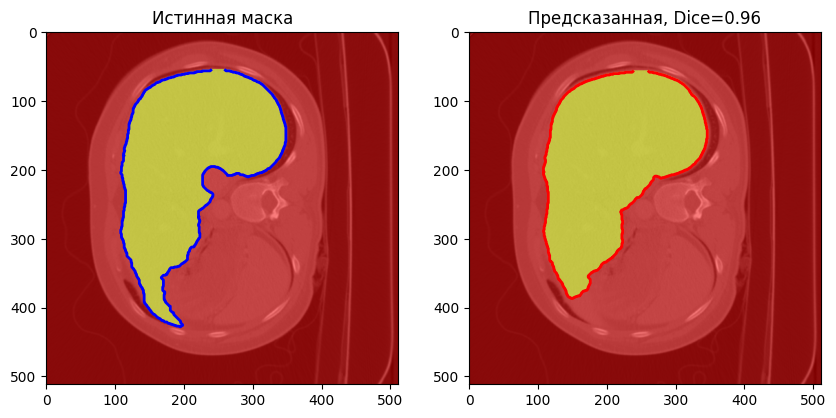

In [111]:
show_result(df_test, 100)

In [26]:
unet_model = unet_model.eval()

In [27]:
evaluate(unet_model, tr_loader)

Test: 100%|██████████| 481/481 [00:23<00:00, 20.39it/s]


(0.6690764019494245, 0.9808187187337578)

In [28]:
evaluate(unet_model, val_loader)

Test: 100%|██████████| 207/207 [00:04<00:00, 43.74it/s]


(0.6737860792500961, 0.9046493014275739)

In [112]:
torch.save(unet_model, 'liver_512_0.90')

In [29]:
i = 0
index_coef = []
for x, y in tqdm(df_test):
    x, y = x.to(device).float().unsqueeze(0), y.to(device).float()
    pred = unet_model(x) > 0.9
    dice_coef = DiceCoef()(pred, y)

    index_coef.append([i, dice_coef.item()])
    
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    # ax1.imshow(x.cpu().squeeze(0).squeeze(0), cmap='gray')
    # ax2.imshow(y.cpu(), cmap='gray')
    # ax3.imshow(pred.cpu().detach().squeeze(0).squeeze(0), cmap='gray')
    # plt.show()
    i += 1
    # if i == 10:
    #     break

100%|██████████| 826/826 [00:05<00:00, 156.84it/s]


In [30]:
index_coef.sort(key=lambda x: x[1])

0.9343605637550354


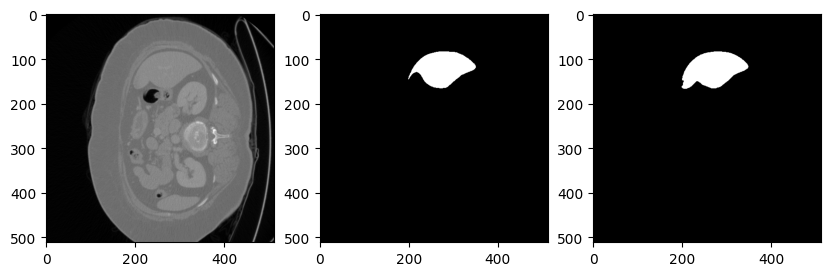

In [36]:
for i in index_coef[150:]:
    data = df_test[i[0]]
    x, y = data[0].to(device).float().unsqueeze(0), data[1].to(device).float()
    pred = unet_model(x) > 0.9
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    print(i[1])
    ax1.imshow(x.cpu().squeeze(0).squeeze(0), cmap='gray')
    ax2.imshow(y.cpu(), cmap='gray')
    ax3.imshow(pred.cpu().detach().squeeze(0).squeeze(0), cmap='gray')
    plt.show()
    time.sleep(1.5)
    break
    clear_output()
    

In [37]:
np.array(index_coef)[:, 1] > 0.8

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,